<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Globally_and_Locally_Consistent_Image_Completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Globally and Locally Consistent Image Completion**

논문 링크: https://openreview.net/pdf?id=wUq6DdbM6M

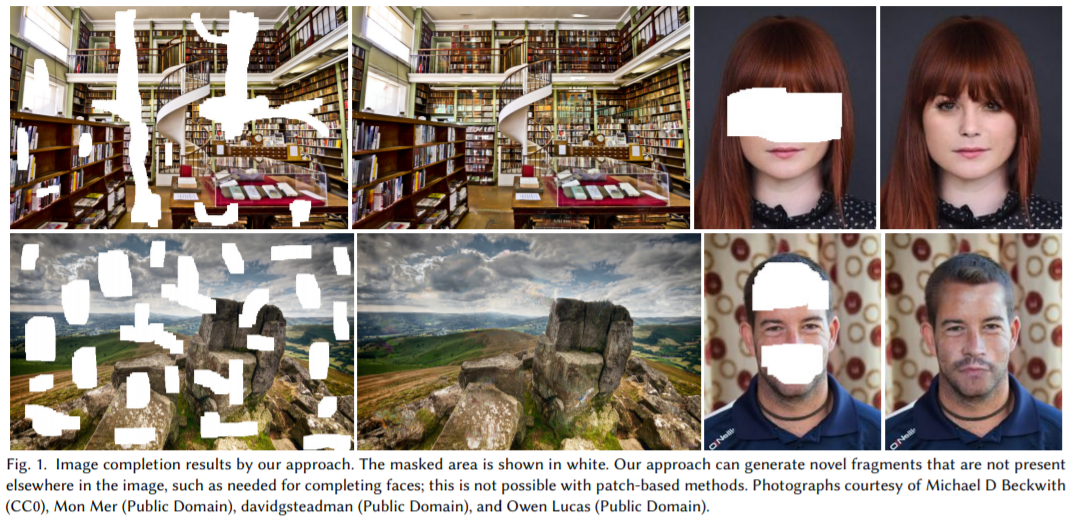

**Image completion**에는 object removal, scene completion, face completion 등 여러 종류가 있다. 이러한 문제들은 texture pattern을 완전히 완성시키기 어려우며 어떤 물체의 구조적인 특징이나 주변 사물과의 연관성 등 교려해야하기 때문에 매우 어려운 문제이다. 본 논문에서는 위의 그림 Fig 1에서 볼 수 있듯이 image에서의 전체 맥락(global)을 고려려하면서 지역적인 부분(local)까지 모두 고려하는 이미지 복구 방법을 제안한다.

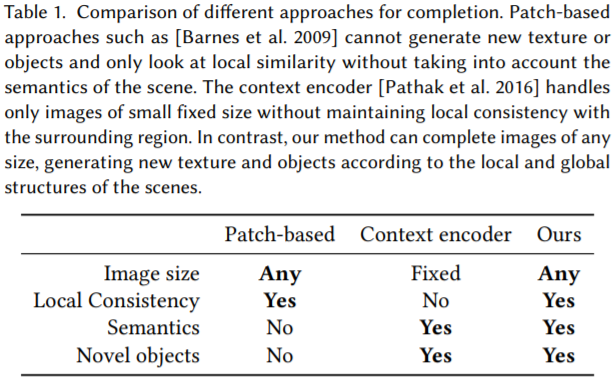

먼저 기존 방식에 대해 알아보겠다.

첫번째로 **Diffusion-based image synthesis**의 경우 일반적으로 오래된 사진에서 흔히 볼 수 있는 스크래치와 같은 작거나 좁은 구멍만 채울 수가 있다.

두번째로 **Patch-based image synthesis** 방식은 크게 비어있는 부분도 채울 수 있지만, patch pixel간의 차 제곱의 합과 같은 저수준 기능에 의존하기 때문에 보다 복잡한 부분을 채울 수 없다.

세번째로 **CNN-based image synthesis** 방식은 매우 작고 얇은 mask에만 적용이 잘되며 좋은 성능이 나온다해도 계산량이 많다는 단점이 있다.

네번째로 **context encoder** 방식은 CNN-based 방식을 확장한 것인데, GAN 기반으로 channel-wise fully-connected layer를 사용했다. 덕분에 큰 mask에도 적용할 수 있게하였지만 위의 표 Table 1과 같이 아직 개선이 필요하다.

## **Model**

본 논문에서는 최근에 제안된 **CE(Context Encoder)** 접근 방식을 기반으로 adversarial loss를 사용한 CNN을 사용한다. 또한, 본 논문에서 제안된 model architecture은 크게 3가지인데, **completion network, global context discriminator, local context discriminator로 구성**이 된다. completion network는 image를 복구하는 용도고, global context discriminator는 image의 전체적인(global한) 맥락을 파악하며, local context discriminator는 image의 세부적인(local한) 부분을 판단한다.

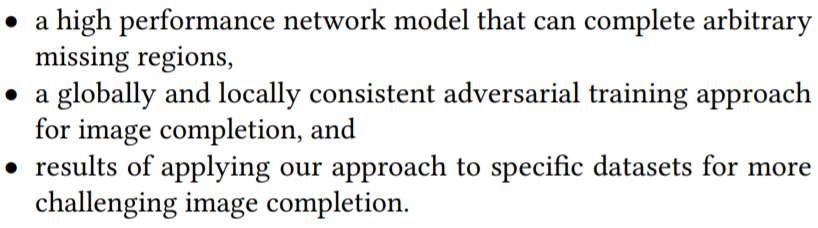

본 논문의 contribution을 요약하자면 위와 같다.

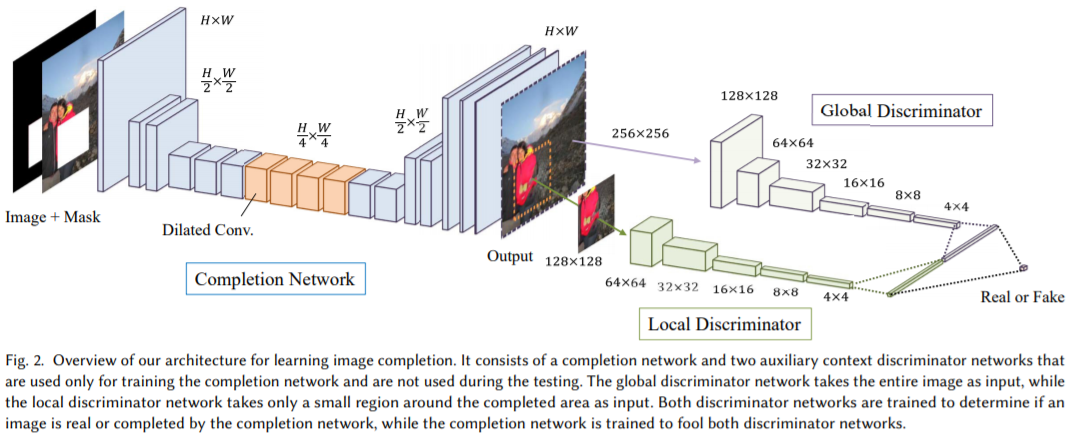

위의 그림 Fig 2에서 전체적인 network의 구조를 보여준다. 원본 image와 mask를 completion network에 input으로 넣어준다. completion network는 image-to-image network답게 down-sampling을 진행한 후 다시 up-sampling을 진행하여 이미지를 완성(completion)해준다. 그 다음 두 개의 discriminator로 global과 local 입장에서 fake인지 real인지 확인하는 adversarial train을 진행한다.

### **Completion network**

Completion network는 위에서 언급했듯이 mask 부분을 완성하는 역할이다. input으로는 RGB 채널의 빈 공간이 있는 image와 이 부분을 masking한 binary channel image가 들어간다. 그리고 encoder, decoder와 비슷한 형식으로 down-sampling에서 feature를 추출하고 다시 up-sampling을 진행하여 빈 공간(mask)을 복구 시킨다.

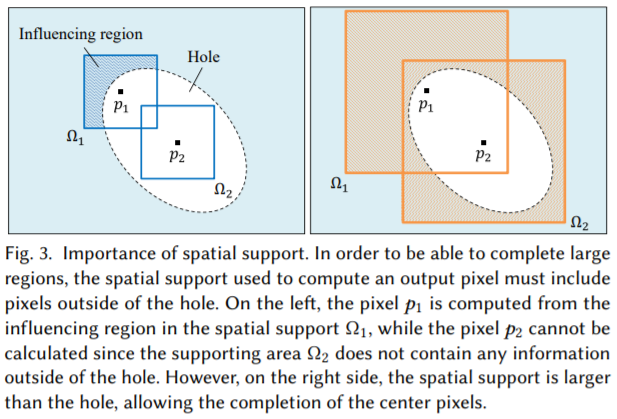

특이한 점이 몇가지 있는데, 첫번째는 오직 strided convolution으로만 image의 해상도 1/4만큼 낮춘다. 그리고 두번째는 **dilated convolution**을 사용한 점이다. 그림 Fig 2에서 노란색 부분에 해당하는 부분이 dilated convolution layer인데, 일반적인 convolution과 parameter의 수와 연산량은 같으면서 위의 그림 Fig 3과 같이 훨씬 더 넓은 부분을 한번에 볼 수 있다는 장점이 있다.(일반적인 convolution layer의 경우는 image의 비어있는 부분을 못 볼 수 있다.)

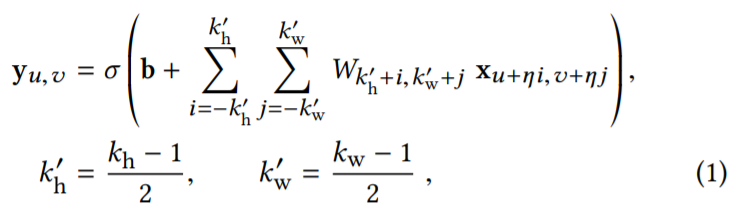

수식은 위와 같다. 이때 k_h와 k_w는 각각 kernel의 높이와 넓이이며, η는 dilation factor로 convolution을 얼마나 더 팽창(dilate)할지 정해주는 hyper-parameter이다. (η가 1이면 일반적인 convolution과 같다.)

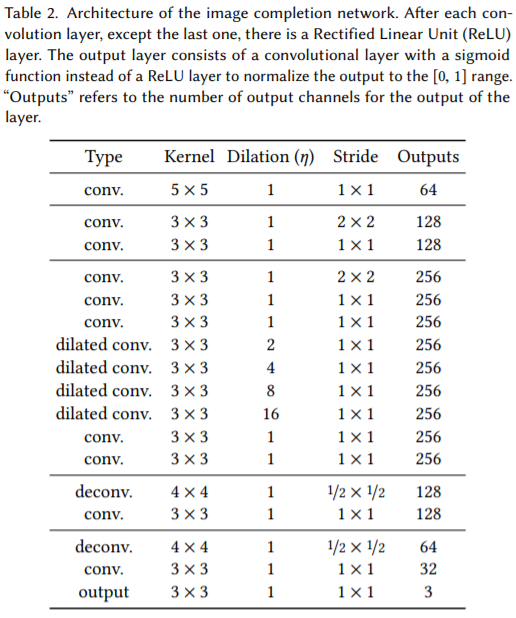

completion network의 자세한 구조는 위의 표 Table 2와 같다.

### **Context Discriminator**

GAN based답게 위의 completion network가 생성한(completion한) image가 실제같은지 아닌지를 판단해야한다. 총 두 개의 discriminator로 전체 image를 input으로 받는 global discriminator와 mask 부분에 해당하는 영역을 input으로 받는 local discriminator를 활용한다. 이 둘은 구조는 비슷하지만, input image의 사이즈만 조금 다르며, 최종적으로 두 discriminator의 output을 concat으로 합쳐 2048 차원의 vector로 real/fake classification을 진행한다.

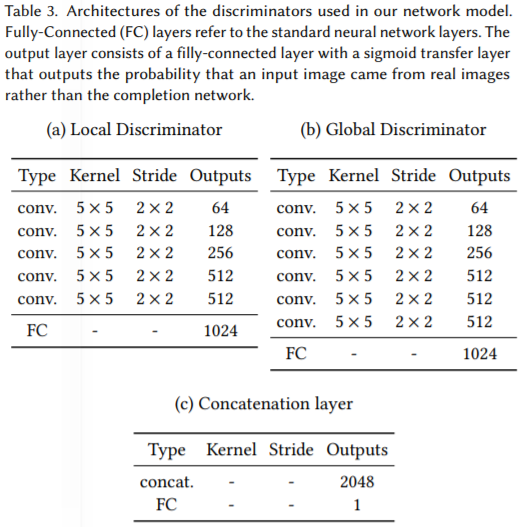

두 discriminator의 자세한 구조는 위의 표 Table 3과 같다.

### **Loss function**

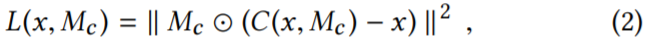

completion region mask에 대한 mse loss는 위의 식과 같다. 이때 ⊙는 pixelwise multiplication을 뜻하며 || ||는 Euclidean norm이다. 또한, M_c는 completion region mask를 뜻한다.

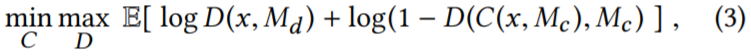

context discriminator의 gan loss는 위의 식과 같다. M_d는 random mask이다.

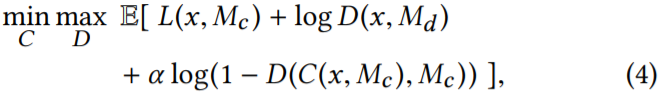

그리고 최종적인 loss는 위와 같다.

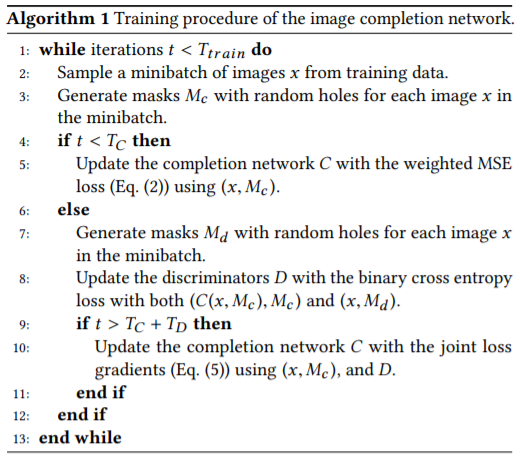

train algorithm은 위와 같은데, completion network를 먼저 학습하고 일정 횟수가 지나면 discriminator를 학습하며 다시 일정 횟수를 넘기면 completion network를 학습하는 식으로 진행이 된다.

## **Experiments**

본 논문에서는 Places2 dataset을 사용하여 8,097,967개의 image를 학습하였다. completion network는 90,000번, discriminator는 10,000번의 iteration를 거쳤으며 4개의 K80을 장착한 기계가 무려 두달이라는 시간을 들여 학습이 되었다...

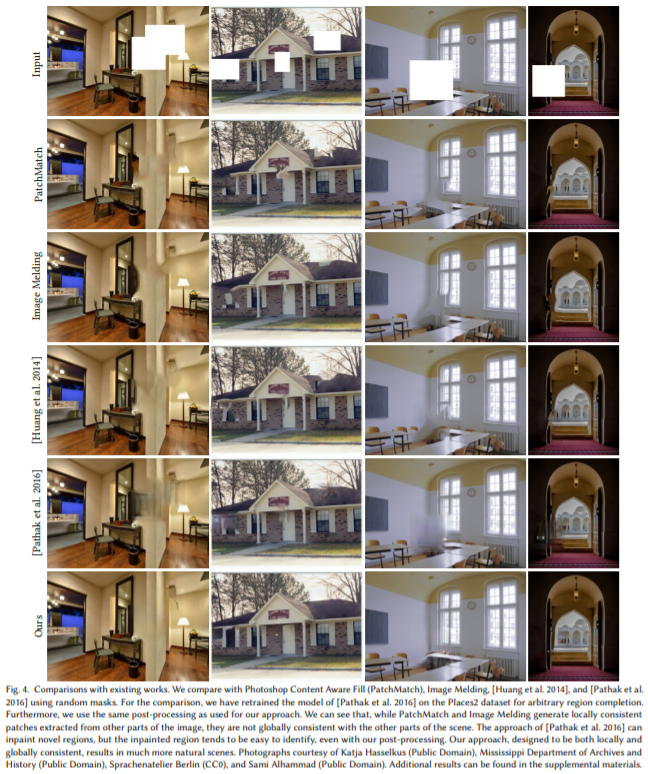

위의 그림 Fig 4는 기존 방식(PatchMatch 등)과 비교한 것이다. 본 논문의 방식은 global과 local을 전체적으로 일관되게끔 설계했기 때문에 보다 더 자연스럽다.

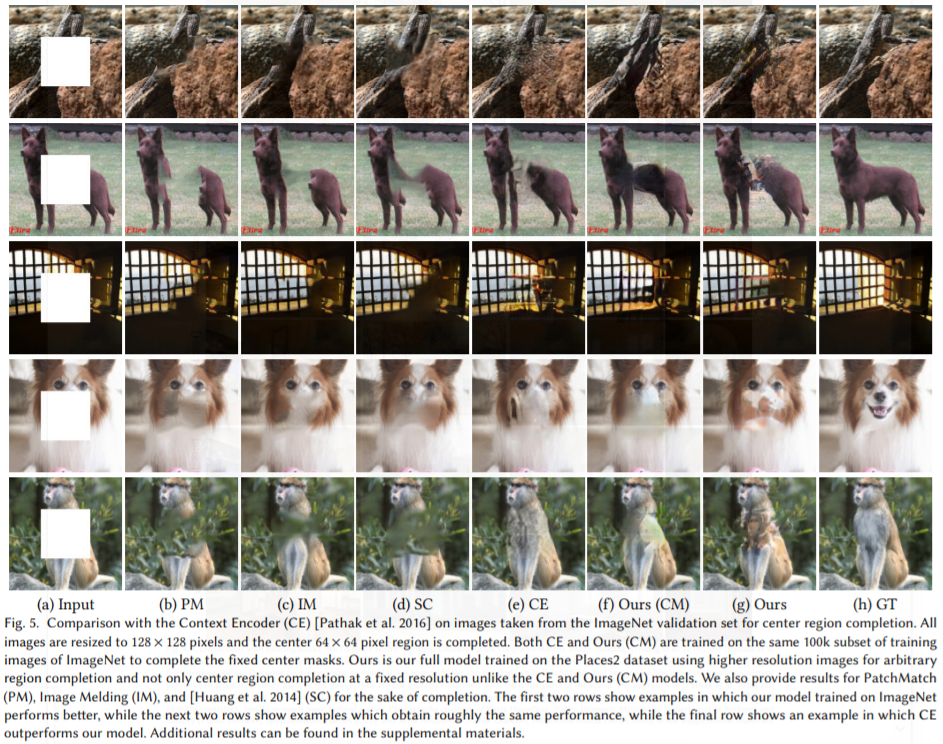

위의 그림 Fig 5의 경우는 첫번째와 두번째는 자연스럽게 잘 만들어졌지만, 마지막 두개의 행은 별로 좋은 성능을 보여주지 못한다.

그 외에 CelebA dataset을 활용하거나, loss를 어떻게 지정했냐에 따른 실험 결과도 있으니 직접 논문에 들어가서 찾아보는 것을 추천한다.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://www.youtube.com/watch?v=5Ua4NUKowPU', width=600, height=480)

마지막으로 이 기술을 활용한 영상이 있어서 가져왔다.